# FORESEE Tutorial - Heavy Neutral Leptons (HNLs)

### Load Libraries 

In [1]:
import sys
src_path = "/Users/alechewitt/Desktop/Git/FORESEE"
sys.path.append(src_path)

import numpy as np
from src.foresee import Foresee, Utility, Model

import src.foresee as fs

from matplotlib import pyplot as plt

## 1. Initialization 


All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

HNL's are produced mainly via $\text{D}^+_s$ meson decay. To start, let us have a look at the $\text{D}^+_s$ spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. The units on the coloraxis are pb/bin. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\text{D}^+_s$, $\eta$, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. Let us show the $\text{D}^+_s$ spectrum here. 

In [3]:
'''plot=foresee.get_spectrumplot(pid="431", generator="pythia8", energy="14")
plot.show()'''

'plot=foresee.get_spectrumplot(pid="431", generator="pythia8", energy="14")\nplot.show()'

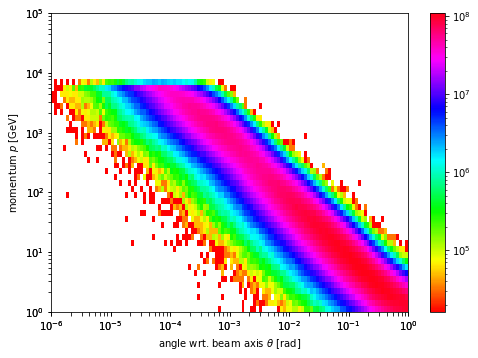

In [4]:
#B-c
plot=foresee.get_spectrumplot(pid="3122", generator="QGSJET", energy="14")
plot.show()

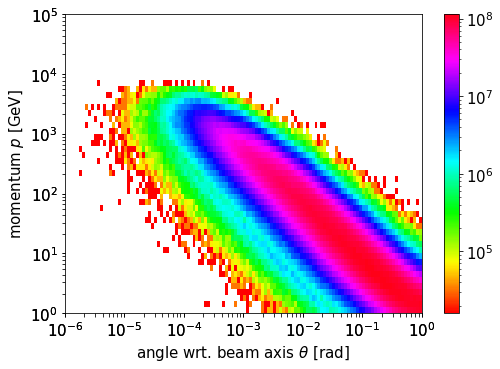

In [5]:

plot=foresee.get_spectrumplot(pid="-323", generator="EPOSLHC", energy="14")
plot.show()

In [6]:
#B-
'''plot=foresee.get_spectrumplot(pid="-521", generator="pythia8", energy="100")
plot.show()'''

'plot=foresee.get_spectrumplot(pid="-521", generator="pythia8", energy="100")\nplot.show()'

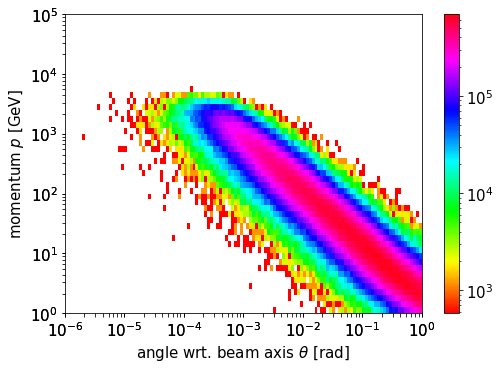

In [7]:
#B-c
plot=foresee.get_spectrumplot(pid="431", generator="pythia8", energy="14")
plot.show()

## 2. Specifying the Model: Heavy Neutral Leptons

The phenomenology of a right handed Heavy Neutral Lepton $\tilde{N}$ can be described by the following Lagrangian

\begin{equation}
 \mathcal{L}_{HNL}=i \bar{\tilde{N}} \gamma^{\mu} \partial_{\mu} \tilde{N} - F_{\alpha } \bar{L}_{\alpha} \tilde{N} \tilde{\Phi}- \frac{1}{2} \bar{\tilde{N}}^c M_N \tilde{N} + \rm{h.c.}
\end{equation}

with the HNL masses $M_N$ and the Yukawa couplings to SM leptons $F_{\alpha}$ as free parameters with $\alpha=e,\mu, \tau$. For the search for HNL's at forward experiments we need to know i) the *production rate*, ii) the *lifetime* and iii) possibly the *decay branching fractions* of HNL's as function of the two sets parameters. All properties are specified in the `Model` class. We initialize it with the name of the model as argument. Optionally, we can also add the `path` to the directory where the model is stored. 

In [8]:
#BR_e = g^2 U_e^2
#define ratios for lepton couplings
energy = "14"
modelname="HNL"
model = Model(modelname, path="./")
masse=0.000511 #GeV mass of electron, in this case because we consider D+ -> e + N

**Production** Most LLPs are produced in the decay of primary particles. Here we need to specify the total branching fraction into the LLP as function of the `coupling` and the `mass`. We additionally specify the variable `nsample` which specifies how often each parent particle is decayed. 

For the HNL, we have the branching fraction

\begin{equation}
    \text{Br} \left(H^+ \rightarrow \ell_{\alpha}^{+} N \right) = \tau_H \frac{G_F^2 f_H^2 M_H M_N^2}{8 \pi} |V_H|^2 |U_{\alpha}|^2 \cdot \left( 1- \frac{M_N^2}{M_H^2} + 2 \frac{M_{\ell}^2}{M_H^2}+ \frac{M_{\ell}^2}{M_N^2} \left( 1- \frac{M_{\ell}^2}{M_H^2} \right) \right)\times \sqrt{\left(1+ \frac{M_N^2}{M_H^2}- \frac{M_{\ell}^2}{M_H^2}\right)^2 - 4 \frac{M_N^2}{M_H^2}}
\end{equation}

There is also the option for 3-body decays $p_0 \to p_1 p_2 p_3$ with $p_3$ being the LLP. This can be added using the function `add_production_3bodydecay()`. It requires to provide `br` which is the dim3erential branching fraction $d\text{BR}/(dq \ d\cos\vartheta)$ where $q^2=(p_2+p_3)^2$ and $\vartheta$ is the angle between $p_3$ in the restframe of $p_2+p_3$ and the direction of $p_2+p_3$ in the restframe of $p_0$. We do not have an example for this in the dark photon case. 

In [9]:
#functions to show br curve
#need to figure out how to delete this function
'''
def integrate_pseud_3body(df,pid0,pid1,pid2,m3,coupling,nsample,channel="D"):
    self=model
    tauH=df.loc[df['pid0']==pid0]['tauH (sec)'].values[0]
    VHHp=df.loc[df['pid0']==pid0]['VHHp'].values[0]
    pid1=df.loc[df['pid0']==pid0]['pid1'].values[0]
    SecToGev=1./(6.582122*pow(10.,-25.))
    tauH=tauH*SecToGev
    GF=1.166378*10**(-5) #GeV^(-2)
    prefactor=f"{tauH}*{coupling}**2*{VHHp}**2*{GF}**2/(64*np.pi**3*self.masses('{pid0}')**2)"
    if channel=="D":
        f00=.747 #for D mesons
        fp0=f00 #for D mesons
        MV=2.01027 #mass in GeV for D mesons
        MS=2.318    #mass in GeV for D mesons
    if channel=="B":
        f00=0.66
        fp0=f00 #for B mesons
        MV=6.2749 #for Bc meson, I think this should also work for Bc* meson (probly not actually)
        MS=5.4154 
        #MS=1.969
    if channel=="Bs":
        f00=0.57
        fp0=f00
        MV=6.2749 #for Bc meson, I think this should also work for Bc* meson (probly not actually)
        MS=5.4154 
    if channel=="Bc->B":
        f00=-0.58
        fp0=f00
        MV=6.2749 #for Bc meson, I think this should also work for Bc* meson (probly not actually)
        MS=5.4154 
    if channel=="Bc->Bs":
        f00=-0.61
        fp0=f00
        MV=6.2749 #for Bc meson, I think this should also work for Bc* meson (probly not actually)
        MS=5.4154 
    m0=self.masses(pid0)
    m1=self.masses(pid1)
    m2=self.masses(pid2)
    pidk="-321"
    pidpi="211"
    fp=f"{f00}/(1-q**2/{MV}**2)"
    f0=f"{f00}/(1-q**2/{MS}**2)"
    fm=f"({f0}-{fp})*(self.masses('{pid0}')**2-self.masses('{pid1}')**2)/q**2"
    term1=f"({fm})**2*(q**2*(m3**2+self.masses('{pid2}')**2)-(m3**2-self.masses('{pid2}')**2)**2)"
    term2=f"2*({fp})*({fm})*m3**2*(2*self.masses('{pid0}')**2-2*self.masses('{pid1}')**2-4*EN*self.masses('{pid0}')-self.masses('{pid2}')**2+m3**2+q**2)"
    term3=f"(2*({fp})*({fm})*self.masses('{pid2}')**2*(4*EN*self.masses('{pid0}')+ self.masses('{pid2}')**2-m3**2-q**2))"
    term4=f"({fp})**2*(4*EN*self.masses('{pid0}')+self.masses('{pid2}')**2-m3**2-q**2)*(2*self.masses('{pid0}')**2-2*self.masses('{pid1}')**2-4*EN*self.masses('{pid0}')-self.masses('{pid2}')**2+m3**2+q**2)"
    term5=f"-({fp})**2*(2*self.masses('{pid0}')**2+2*self.masses('{pid1}')**2-q**2)*(q**2-m3**2-self.masses('{pid2}')**2)"
    bra=str(prefactor)  + "*(" + term1   + "+(" + term2  + "+" + term3 + ")+("  + term4   + "+" + term5 + "))"
   
    integ=foresee.integrate(bra, 1, m0, m1, m2,m3, nsample)
    return(integ)

#need to eventually delete this as well
def integrate_vec_3body(df,pid0,pid1,pid2,m3,coupling,bra,nsample):
    self=model
    bra=dbr_3_body_vector(df,pid0,pid1,pid2)
    m0=self.masses(f'{pid0}')
    m1=self.masses(f'{pid1}')
    m2=self.masses(f'{pid2}')
    integ=foresee.integrate(bra, 1, m0, m1, m2,m3, nsample)
    return(integ)

def integrate_q2EN(pid0,pid1,pid2,m3,coupling,dbr,nsample):
    m0=self.masses(f'{pid0}')
    m1=self.masses(f'{pid1}')
    m2=self.masses(f'{pid2}')
    integ=foresee.integrate(dbr, 1, m0, m1, m2,m3, nsample)
    return(integ)

#pid0 is parent particle, pid1 is produced meson pid2 is the smaller particle
#modified for felix
def show_br_curve(br,pid0,pid1,pid2,integration,nsample=100):
    if integration=='br':
        self=model
        coupling=1
        delm=.1
        mass0=0
        mass=0.01
        x=[]
        y=[]
        for n in range(1,int((3-mass0)/delm)):
            y.append(eval(br))
            x.append(mass)
            mass+=delm

        plt.plot(x,y)
        plt.xlim([0,3])
        plt.ylim([0,max(y)])
        plt.xlabel(r"$m_N (GeV)$")
        plt.ylabel(r"Br")

    if integration=='dEN':
        dbr=br
        self=model
        m0=self.masses(f"{pid0}")
        m1=self.masses(f"{pid1}")
        m2=self.masses(f"{pid2}")
        qmin,qmax=(m2+m3),(m0-m1)
        coupling=1
        delm=.1
        x=[]
        y=[]
        m3=.01
        for n in range(1,17):
            y.append(foresee.integrate_EN(dbr, 1, m0, m1, m2,m3, nsample))
            x.append(m3)
            m3+=delm
        plt.ylim([0,max(y)])
        plt.xlabel(r"$m_N (GeV)$")
        plt.ylabel(r"Br")
        plt.plot(x,np.array(y))

    if integration=='dq2dEN':
        self=model
        dbr=br
        m0=self.masses(f"{pid0}")
        m1=self.masses(f"{pid1}")
        m2=self.masses(f"{pid2}")
        coupling=1
        delm=.1
        x=[]
        y=[]
        m3=0
        for n in range(1,30):
            y.append(integrate_q2EN(pid0,pid1,pid2,m3,coupling,dbr,nsample))
            #y.append(integrate_pseud_3body(df,pid0,pid1,pid2,m3,1,nsample=nsample,channel="D"))
            x.append(m3)
            m3+=delm
        plt.ylim([0,max(y)])
        plt.xlabel(r"$m_N (GeV)$")
        plt.ylabel(r"Br")
        plt.plot(x,np.array(y))

    plt.show()
'''


'\ndef integrate_pseud_3body(df,pid0,pid1,pid2,m3,coupling,nsample,channel="D"):\n    self=model\n    tauH=df.loc[df[\'pid0\']==pid0][\'tauH (sec)\'].values[0]\n    VHHp=df.loc[df[\'pid0\']==pid0][\'VHHp\'].values[0]\n    pid1=df.loc[df[\'pid0\']==pid0][\'pid1\'].values[0]\n    SecToGev=1./(6.582122*pow(10.,-25.))\n    tauH=tauH*SecToGev\n    GF=1.166378*10**(-5) #GeV^(-2)\n    prefactor=f"{tauH}*{coupling}**2*{VHHp}**2*{GF}**2/(64*np.pi**3*self.masses(\'{pid0}\')**2)"\n    if channel=="D":\n        f00=.747 #for D mesons\n        fp0=f00 #for D mesons\n        MV=2.01027 #mass in GeV for D mesons\n        MS=2.318    #mass in GeV for D mesons\n    if channel=="B":\n        f00=0.66\n        fp0=f00 #for B mesons\n        MV=6.2749 #for Bc meson, I think this should also work for Bc* meson (probly not actually)\n        MS=5.4154 \n        #MS=1.969\n    if channel=="Bs":\n        f00=0.57\n        fp0=f00\n        MV=6.2749 #for Bc meson, I think this should also work for Bc* meson (p

In [10]:
import pandas as pd

#n can be: 2 for 2-body and 3 for 3-body. type can be: 2 body regular, 2 body tau to pi, 2 body tau to K, 2 body tau to rho, 3 body pseudo, 3 body vector, 3 body tau
#pid0 is parent pid1 is produces meson pid2 is the smaller particle, usually the electron
#for 2 body pid0 is the parent and pid1 is the produced SM particle
def add_nbodydecay(pid0,pid1,pid2,energy='14',nsample=10,generator="Pythia8",n=2,type_decay="2 body regular",show_br=True):
    if n==2 and type_decay=="2 body regular":
        df=pd.DataFrame([],columns=['particle','pid0','tauH (sec)','MH (GeV)','VH (unitless)','fH (GeV)','process'])
        particles=[['D^+','411',1040*10**(-15),1.8696,.221,.2226,'D^+ -> e^+ + N'],['D^+_s','431',500*10**(-15),1.96847,0.987,.2801, 'D_s^+ -> e^+ + N'],['B^+','521',1.638*10**(-12),5.27934,3.82*10**(-3),0.187,'B^+ -> e^+ + N'],['B^+_c','541',0.510*10**(-12),6.2749,41*10**(-3),.434, 'B^+_c -> e^+ + N']]
        for n in range(len(particles)):
            df.loc[len(df)]=particles[n]
        br=foresee.br_2_body(pid0,pid1)
        model.add_production_2bodydecay(
        pid0 = f"{pid0}",
        pid1 = f"{pid1}",
        br=br,
        generator = generator,
        energy = energy,
        nsample = nsample
        )
        if show_br==True:
            foresee.show_br_curve(br,pid0,pid1=pid1,pid2=pid2,integration='br',nsample=nsample)
        #show_br_curve(df,br,pid0,pid1=None,pid2=pid2,decay_type='2 body',nsample=nsample)
        
    if n==2 and type_decay=="2 body tau":
        df=pd.DataFrame([],columns=['pid0','pid1','process'])
        particles=[['15','-211','tau^- -> pi^- + N'],['15','-321','tau^- -> K^- + N'],['15','-213','tau^- -> rho^- + N']]
        for n in range(len(particles)):
            df.loc[len(df)]=particles[n]

        if pid1=="-213" or pid1=="213":
            br=foresee.br_2_body_tau_rho(pid0,pid1)
        else:
            br=foresee.br_2_body_tau_H(pid0,pid1)

        model.add_production_2bodydecay(
            pid0 = f"{pid0}",
            pid1 = f"{pid1}",
            br=br,
            generator = generator,
            energy = energy,
            nsample = nsample
        )
        if show_br==True:
            foresee.show_br_curve(br,pid0,pid1=pid1,pid2=pid2,integration='br',nsample=nsample)
        
    #here its kinda flipped pid1 is the electron now and pid2 is the neutrino
    if n==3 and type_decay=="3 body tau":
        df=pd.DataFrame([],columns=['pid0','pid1','pid2','process'])
        particles=[['15','11','18','tau^- -> e^- + nu_tau']]
        for n in range(len(particles)):
            df.loc[len(df)]=particles[n]
        dbr=foresee.dbr_3_body_tau(pid0,pid1,pid2)
        #for another type of decay
        #prefactor=f"({tautau}*coupling**2*{GF}**2*self.masses('{pid0}')**2/(4*np.pi**3))"
        #dbr=f"{prefactor}*(1-self.masses('{pid1}')**2/(self.masses('{pid0}')**2+mass**2-2*EN*self.masses('{pid0}')))**2*np.sqrt(EN**2-mass**2)*((self.masses('{pid0}')-EN)*(1-(mass**2+self.masses('{pid1}')**2)/self.masses('{pid0}')**2)-(1-self.masses('{pid1}')**2/(self.masses('{pid0}')**2+mass**2-2*EN*self.masses('{pid0}')))*((self.masses('{pid0}')-EN)**2/self.masses('{pid0}')+((EN**2-mass**2)/(3*self.masses('{pid0}')))))"
        model.add_production_3bodydecay(
            label= "5_di",
            pid0 = pid0,
            pid1 = pid1,
            pid2 = pid2,
            br = dbr,
            generator ="pythia8",
            energy = energy,
            nsample = nsample,
            scaling = 0, 
        )
        if show_br==True:
            foresee.show_br_curve(br,pid0,pid1,pid2,integration="dEN",nsample=nsample)
        #show_br_curve(df,dbr,pid0,pid1=pid1,pid2=pid2,decay_type='3 body',nsample=nsample)
        
    if n==3 and type_decay=="3 body pseudo":
        df=pd.DataFrame([],columns=['process','pid0','pid1','tauH (sec)','VHHp'])
        particles=[['D^+ -> \bar{K}^0 + l + N','411','-311',1040*10**(-15),0.987],
        ['D^- -> \bar{K}^0 + l + N','-411','-311',1040*10**(-15),0.987],
        ['D^0 -> K^- + l + N','421','-321',410.1*10**(-15),0.997],
        ['B^+ -> \bar{D}^0 + l + N','521','421',1.638*10**(-12),41*10**(-3)],
        ['B^0 -> D^- + l + N','511','-411',1.519*10**-12,42.2*10**-3],
        ['B^0_s -> D^-_s + l + N','531','-431',1.515*10**-12,42.2*10**-3],
        ['B^+_c -> B^0 + l + N','541','511',0.510*10**-12,0.221],
        ['B^+_c -> B^0_s + l + N','541','531',0.510*10**-12,0.987]]
        for n in range(len(particles)):
            df.loc[len(df)]=particles[n]
        dbr=foresee.dbr_3_body_pseudo(pid0,pid1,pid2)
        model.add_production_3bodydecay(
        label= "5_di",
        pid0 = pid0,
        pid1 = pid1,
        pid2 = pid2,
        br = dbr,
        generator = "Pythia8",
        energy = energy,
        nsample = nsample,
        scaling = 0)
        if show_br==True:
            foresee.show_br_curve(dbr,pid0,pid1,pid2,integration="dq2dEN",nsample=nsample)
        #show_br_curve(df,dbr,pid0,pid1=pid1,pid2=pid2,decay_type='3 body pseudo',nsample=nsample)

    if n==3 and type_decay=="3 body vector":
        df=pd.DataFrame([],columns=['process','pid0','pid1','tauH (sec)','VHHp'])
        particles=[['D^0 -> K*^- + e^+ + N','421','-323',410.1*10**(-15),0.967],['B^+ -> \bar{D}*^0 + e^+ + N','521','-423',1.638*10**-12,41*10**-3],['B^0 -> D*^- + e^+ + N','511','-413',1.519*10**-12,41*10**-3],['B^0_s -> D^*_s^- + e^+ + N','531','-433',1.515*10**-12,41*10**-3],['B^+_c -> B*^0 + e^+ + N','541','513',.510*10**-12,.221],['B^+_c -> B^*_s^0+ e^+ + N','541','533',.510*10**-12,41*10**-3]]
        for n in range(len(particles)):
            df.loc[len(df)]=particles[n]
        dbr=foresee.dbr_3_body_vector(pid0,pid1,pid2)
        model.add_production_3bodydecay(
        label= "5_di",
        pid0 = pid0,
        pid1 = pid1,
        pid2 = pid2,
        br = dbr,
        generator = "Pythia8",
        energy = energy,
        nsample = nsample,
        scaling = 0)
        if show_br==True:
            foresee.show_br_curve(dbr,pid0,pid1,pid2,integration="dq2dEN",nsample=nsample)




/Users/alechewitt/Desktop/Git/FORESEE/src/foresee.py:1108: RuntimeWarning: invalid value encountered in sqrt
  m232min = (E2st + E3st)**2 - (np.sqrt(E2st**2 - m3**2) + np.sqrt(E3st**2 - m1**2))**2
/Users/alechewitt/Desktop/Git/FORESEE/src/foresee.py:1109: RuntimeWarning: invalid value encountered in sqrt
  m232max = (E2st + E3st)**2 - (np.sqrt(E2st**2 - m3**2) - np.sqrt(E3st**2 - m1**2))**2


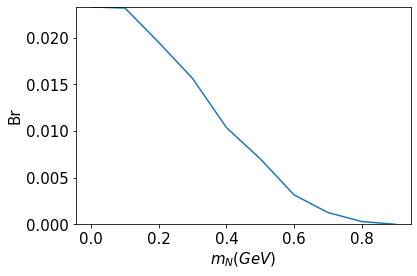

In [11]:
#for testing functions
#for 2 body decays
df=pd.DataFrame([],columns=['particle','pid0','tauH (sec)','MH (GeV)','VH (unitless)','fH (GeV)','process'])
particles=[['D^+','411',1040*10**(-15),1.8696,.221,.2226,'D^+ -> e^+ + N'],['D^+_s','431',500*10**(-15),1.96847,0.987,.2801, 'D_s^+ -> e^+ + N'],['B^+','521',1.638*10**(-12),5.27934,3.82*10**(-3),0.187,'B^+ -> e^+ + N'],['B^+_c','541',0.510*10**(-12),6.2749,41*10**(-3),.434, 'B^+_c -> e^+ + N']]
for n in range(len(particles)):
    df.loc[len(df)]=particles[n]

#for 2 body decays tau
df_t=pd.DataFrame([],columns=['pid0','pid1','process'])
particles=[['15','-211','tau^- -> pi^- + N'],['15','-321','tau^- -> K^- + N'],['15','-213','tau^- -> rho^- + N']]
for n in range(len(particles)):
    df_t.loc[len(df_t)]=particles[n]

#for 3 body decays tau
df_3t=pd.DataFrame([],columns=['pid0','pid1','pid2','process'])
particles=[['15','11','18','tau^- -> e^- + nu_tau']]
for n in range(len(particles)):
    df_3t.loc[len(df_3t)]=particles[n]

#for 3 body pseudo
df_D=pd.DataFrame([],columns=['particle','pid0','pid1','tauH (sec)','VHHp'])
particles=[['D^+ -> \bar{K}^0 + l + N','411','-311',1040*10**(-15),0.987],['D^- -> \bar{K}^0 + l + N','-411','-311',1040*10**(-15),0.987],['D^0 -> K^- + l + N','421','-321',410.1*10**(-15),0.997],['B^+ -> \bar{D}^0 + l + N','521','421',1.638*10**(-12),41*10**(-3)],['B^0 -> D^- + l + N','511','-411',1.519*10**-12,42.2*10**-3],['B^0_s -> D^-_s + l + N','531','-431',1.515*10**-12,42.2*10**-3],['B^+_c -> B^0 + l + N','541','511',0.510*10**-12,0.221],['B^+_c -> B^0_s + l + N','541','531',0.510*10**-12,0.987]]
for n in range(len(particles)):
    df_D.loc[len(df_D)]=particles[n]

#for 3 body vector
df=pd.DataFrame([],columns=['particle','pid0','pid1','tauH (sec)','VHHp'])
particles=[['D^0 -> K*^- + e^+ + N','421','-323',410.1*10**(-15),0.967],['B^+ -> \bar{D}*^0 + e^+ + N','521','-423',1.638*10**-12,41*10**-3],['B^0 -> D*^- + e^+ + N','511','-413',1.519*10**-12,41*10**-3],['B^0_s -> D^*_s^- + e^+ + N','531','-433',1.515*10**-12,41*10**-3],['B^+_c -> B*^0 + e^+ + N','541','513',.510*10**-12,.221],['B^+_c -> B^*_s^0+ e^+ + N','541','533',.510*10**-12,41*10**-3]]
for n in range(len(particles)):
    df.loc[len(df)]=particles[n]

pid0='421'
pid1='-323'
pid2='-11'
integration="dq2dEN"
#integration="br"
add_nbodydecay(pid0,pid1,pid2,energy='14',nsample=100,generator="Pythia8",n=3,type_decay="3 body vector",show_br=True)
#print(self.masses('421'),self.masses('-323'),self.masses('15'))


We can also produce the dark photon via it's resonant mixing with the SM vector mesons, in particular the $\omega$, $\rho$ and $\phi$ mesons. Following [arXiv:1810.01879](https://arxiv.org/pdf/1810.01879.pdf), we can write 

\begin{equation}
    \sigma(A') = \theta_V^2 \  \sigma(V)
    \quad\quad\text{with}\quad\quad
    \theta_V = \frac{\epsilon e}{g_V}  \frac{m_V^2}{m_{A'}^2 - m_V^2 + i m_V \Gamma_V}
\end{equation}

Here $g_\omega = 17$, $g_\rho=5$ and $g_\phi=-12.88$. We can specify this production mode using `model.add_production_mixing()`. In the following, we focus on the $\rho$, which provides the leading contribution. 

Particles can also be produced directly in collisions. In the case of dark photons, this proceeds through Bremsstrahlung at lower masses or through Drell-Yan production at higher masses. The spectra for LLPs at some reference coupling need to be provided for a fixed set of masses in the `model/direct` directory. We also provide an option to implement additional conditions in terms of the momentum `p`, in this case the requirement that pT of dark photon produced in Bremssteahlung is smaller than 1 GeV.

**Lifetime:** For most models the lifetime can be written as $\ c\tau(m,g)\  =\  c\tau(m,g_*) \ \cdot\  g_*^2 \ / \ g^{2}$ where $m$ is the mass, $g$ is the coupling and $g_*$ is some reference coupling. In this case, we can provide a table of masses $m$ and lifetimes $c\tau(m,g_*)$ at a reference coupling $g_*$ using `model.set_ctau_1d`. Alternatively, one can also provide a table of masses $m$, couplings $g$ and lifetimes $c\tau(m,g)$ via `model.set_ctau_2d()`. 

In [12]:
model.set_ctau_1d(
    filename="model/ctau_tau.txt", 
    coupling_ref=10**-3.5
)

**Branching Fractions:** For most models, the branching fractions into particular decay channels are independent of the overall couplings. In this case, we can provide a set of tables of masses $m$ and branching fractions $BR(m)$ using `model.set_br_1d`. Alternatively, we can also provide table of masses $m$, couplings $g$ and branching fraction $BR(m,g)$ via `model.set_br_2d()`. In both cases, we need to specify a list of decay modes and a list of filenames with the corresponding data tables. 

In [13]:
'''model.set_br_1d(
    modes=["e_mu", "e_tau"],
    finalstates=[[11,13], [11,15]],
    filenames=["model/br/br_elecmuon.txt","model/br/br_electau.txt"]
)'''

'model.set_br_1d(\n    modes=["e_mu", "e_tau"],\n    finalstates=[[11,13], [11,15]],\n    filenames=["model/br/br_elecmuon.txt","model/br/br_electau.txt"]\n)'

## 3. Generate LLP Spectra

After we have specified the model, let us generate the LLP spectra. We first set the model we just created. 

In [14]:
foresee.set_model(model=model)

Let's first look at one benchmark scenario with $M_{N}=1$ GeV and $\epsilon=10^{-3.5}$ using the function `foresee.get_llp_spectrum()`. By default, the result are saved in the `model/LLP_spectra` directory. However, here set `save_file=False` since we don't want to save the results but set `do_plot=True` to plot them. 

In [15]:
gene='PYTHIA8'
pidd='-15'
pidp='431'
'''particles=[['D^+','411',1040*10**(-15),1.8696,.221,.2226],['D^+_s','431',500*10**(-15),1.96847,0.987,.2801],['B^+','521',1.638*10**(-12),5.27934,3.82*10**(-3),0.187],['B^+_c','541',0.510*10**(-12),6.2749,41*10**(-3),.434]]
'''

"particles=[['D^+','411',1040*10**(-15),1.8696,.221,.2226],['D^+_s','431',500*10**(-15),1.96847,0.987,.2801],['B^+','521',1.638*10**(-12),5.27934,3.82*10**(-3),0.187],['B^+_c','541',0.510*10**(-12),6.2749,41*10**(-3),.434]]\n"

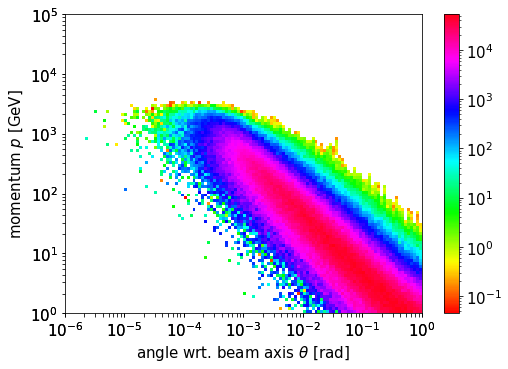

In [16]:
#SIBYLL, EPOSLHC, QGSJET, PYTHIA
#integration can be "dq2dcosth", "dq2dEN", "dEN"
plot = foresee.get_llp_spectrum(0.0000000000000000001, coupling=1,integration=integration, do_plot=True, save_file=False)

We can now produce a set of LLP spectra for various masses  (chosen to be equally spaced in log(mass)) and unit coupling and save them. 

In [ ]:
'''masses = [ 
    0.01  ,  0.0126,  0.0158,  0.02  ,  0.0251,  0.0316,  0.0398,
    0.0501,  0.0631,  0.0794,  0.1   ,  0.1122,  0.1259,  0.1413,
    0.1585,  0.1778,  0.1995,  0.2239,  0.2512,  0.2818,  0.3162,
    0.3548,  0.3981,  0.4467,  0.5012,  0.5623,  0.6026,  0.631 ,
    0.6457,  0.6607,  0.6761,  0.6918,  0.7079,  0.7244,  0.7413,
    0.7586,  0.7762,  0.7943,  0.8128,  0.8318,  0.8511,  0.871 ,
    0.8913,  0.912 ,  0.9333,  0.955 ,  0.9772,  1.    ,  1.122 ,
    1.2589,  1.4125,  1.5849,  1.7783,  1.9953,  2.2387,  2.5119,
    2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 10.    
]

for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)'''


save data to file: ./model/LLP_spectra/14TeV_431_m_1.0.npy


## 4. Count Event Rate in Detector

Before counting the number of decays within the detector volume, let us specify the detector geometry. For this we need

- the `distance` from the IP in meter (default: 480)
- the `length` in meter (default: 5)
- the `luminosity` in units of fb^-1 (default: 3000)
- the `selection` depending in `x.x` and `x.y` (default: `np.sqrt(x.x**2 + x.y**2)< 1`)
- the decay `channels` which the detector can see (default: None, meaning all of them)

The default correspond to the FASER2 detector.

In [ ]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + x.y**2)< 1", 5, 3000, None
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

Let us look for one specific HNL mass $M_{N}=1$ GeV at how many particle decay inside the decay volume. This can be done using `get_events()` for which we need to specify again the mass and filename. Additionally, we can specify 

- the `couplings` for which we evaluate the event rate as numpy array (deault `np.logspace(-8,-3,51)`)
- the `preselectioncuts` when reading the LLP spectra in terms of momentum `p` and angle `th` (default: `th<0.01 and p>100`)
- the number `nsample` describing how many randomly choosen values of $\phi_{LLP}$ should sampled (default 1). This is only relevant for detectors that are not cylyndrical or not centered around the beam axis. 
- the production `modes` which should be considered
- the `energy` of the experiments

In [ ]:
foresee.get_llp_spectrum(mass=mass,coupling=10**-1)
output = foresee.get_events(mass=mass, energy=energy, couplings=[10**-1])
coups, ctaus, nsigs, energies, weights, _ = output
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print ("epsilon =", '{:5.3e}'.format(coup), ": nsignal =", '{:5.3e}'.format(nsig))

save data to file: ./model/LLP_spectra/14TeV_431_m_1.0.npy
epsilon = 1.000e-01 : nsignal = 3.662e+05


The previous function also outputs the energy distribution of the HNL particles which decay inside the detector. Let's have a look at them.

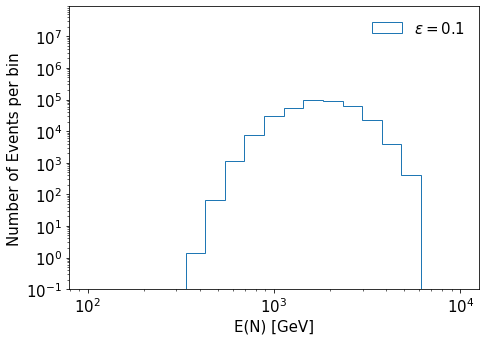

In [ ]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
ens=[]
for coup,en,weight in zip(coups,energies,weights):
    if sum(weight)<9.9*10**1 : continue
    ens.append(en)
    ax.hist(en, weights=weight, bins=np.logspace(2,4, 20), histtype='step', label=r"$\epsilon=$"+str(coup)) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**-1,9*10**7) 
    ax.set_xlabel("E(N) [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False, labelspacing=0)
plt.tight_layout()
plt.show()

FORESEE also includes a function `write_events()` which obtains an unweighted sample of LLP decay events and saves them as a HEPMC file. For this function, we need to specify
- the `mass` and `coupling` of the LLP
- the collision `energy`
- the number of events `numberevent` that should be samples (optional, default=10)
- the `filename` of the output file (optional, default=`model/events/<mass>_<coupling>.hepmc`)
- the z-position (in meter) of the beginning of the decay volume (optional, default=0)
- a random `seed` (optional, default=None)
- the `decaychannels` for which the event should bbe written to file (optional, default=None meaning that all channels are written to file)

At the moment, FORESEE only supports 2-body LLP decays. For all other cases, including those where no final state information was specified when initiating the `Model`, the LLP will not be decayed. 

In [ ]:
'''foresee.write_events(filename="model/events/test.hepmc", mass=1., coupling=1.000e-05, 
    energy="14", numberevent=10, zfront=0, decaychannels=["e_mu"])'''

'foresee.write_events(filename="model/events/test.hepmc", mass=1., coupling=1.000e-05, \n    energy="14", numberevent=10, zfront=0, decaychannels=["e_mu"])'

Let us have a look at a the output:

In [ ]:
'''f = open("model/events/test.hepmc", 'r')
file_contents = f.read()
print (file_contents)'''

'f = open("model/events/test.hepmc", \'r\')\nfile_contents = f.read()\nprint (file_contents)'

## 5. Parameter Scan

In the following, we will get the LLP sensitivity reach for different detector configuraions. As an example, we show the FASER2 reach for dark photons for 3 scenarios. We just need to loop over different masses and use the previously introduced funtion `get_events`. The results will be written into a `.npy` file that we can store and plot later.

- the nominal/default setup

In [ ]:
#this part works, just long run time
#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "default", "np.sqrt(x.x**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy,couplings=np.logspace(-4,-1,50))
    list_nevents.append(nevents)  
    
#save results
np.save(model.modelpath+"model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

NameError: name 'masses' is not defined

- a displaced setup, in which the detector is displaced by 1m from it's nominal position

In [ ]:
#this part works, just long run time
'''
#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "displaced", "np.sqrt((x.x-1)**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy,couplings=np.logspace(-4,-1,50))
    list_nevents.append(nevents)  
    
#save results
np.save(model.modelpath+"model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])'''

- a search that only considered dark photon decays into electrons 

In [ ]:
#this part works, just long run time
'''
#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "e_mu", "np.sqrt(x.x**2 + x.y**2)< 1", ["e_mu"]
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy,couplings=np.logspace(-4,-1,50))
    list_nevents.append(nevents)  
    
#save results
np.save(model.modelpath+"model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])'''

## 6. Plot the Results

Now let's plot the results. We first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [ ]:
setups = [
    ["14TeV_default.npy",    "default"  , "red",     "solid", 0., 3],
]
'''["14TeV_displaced.npy",  "displaced", "orange",  "solid", 0., 3],
    ["14TeV_e_mu.npy",   "e_mu" , "magenta", "solid", 0., 3],'''

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation)

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [ ]:
bounds = [ 
    ["bounds_BBN_el.txt",  "BBN"  , 3*10**-1    , 3*10**-5        , -40  ],
    ["bounds_el.txt",None,  0.220, 0.9*10**-4, 0  ],
    ]

'''["bounds_LHCb_el.txt",  "LHCb"  , 0    , 0         , 0  ]
    ["bounds_el.txt", None,  0.220, 0.9*10**-4, 0  ],
'''

#this one doesnt even show up
#["bounds_LHCb_el.txt",  None  , 0    , 0         , 0  ]


projections = [




    ["limits_SHiP_el.txt",           "orange",  "SHiP"    , 3, 10**-4, 0  ],
    ["limits_NA62_el.txt",           "blue",    "NA62"    ,1, 0.0002 , 0  ],
    ["limits_DUNE_el.txt",           "magenta",    "DUNE"    ,0.6, 0.00009 , 0  ],
    ['limits_CODEX_el.txt',           "purple",    "CODEX"    ,2*10**-1, 0.0003, 0  ],
    ["limits_MATHUSLA_el.txt",           "forestgreen",  "MATHUSLA"    , 0.3, 0.0001 , 0  ]



]






Finally, we can plot everything using `foresee.plot_reach()`. It returns a matplotlib instance, to which we can add further lines and which we can show or save. Below, we add the dark matter relict target line for a specific benchmark.

In [ ]:
import pandas as pd
df_ref=pd.read_csv('/Users/alechewitt/Desktop/Git/FORESEE/Models/HNL/model/reachref.csv')
plot = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="HNL",
    xlims = [10**-1,10], 
    ylims=[10**-4,10**-2],
    xlabel=r"HNL mass $M_{N}$ [GeV]", 
    ylabel=r"Kinetic Mixing $|U_{eN}|$",
    legendloc=(1,0.68),
    figsize=(8,6),
)
plot.plot(MN,UeN, color="k", lw=2)
plot.plot(refx,refy, color="k", lw=2)
plot.plot(X,Y, color="k", lw=2)
plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("/Users/alechewitt/Desktop/Figure.pdf")
plot.show()

## 7. Export Contours

It might also be useful to extract the contours lines, and save them as a text file. This can be done using the `extract_contours()` function. As example, let us export the FASER2 line. 

In [ ]:
foresee.extract_contours(
    inputfile="model/results/14TeV_default.npy", 
    outputfile="model/lines/limits_FASER2.txt"
)

In [80]:
#this portion will take a branching fraction and write to a file in the form m br
def chop(expr, delta=10**-2):
    return np.ma.masked_inside(expr, -delta, delta).filled(0)
f = open("demofile2.txt", "w+")
f.close()
f = open("demofile2.txt", "a")
m=1
br=2
m=.01
delm=.01
steps=int(10/.01)
for n in range(steps):
    #f.write(f"{m}  {br}\n")
    f.write(" {: <10} {: <10}\n".format(*['%.2f' % m,br]))
    m=chop(m+delm)
f.close()
a=.0134155
print('%.2f' % a)

0.01


In [82]:
kron=[[1,0,0],[0,1,0],[0,0,1]]

1